In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
data_directory = "./drive/MyDrive/RAVDESS/"

In [ ]:
cd ../../../


/content


In [3]:
pwd

'/content'

## 2. Install and import libraries

In [4]:
import librosa
import soundfile
import os, glob
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, f1_score
import keras
from keras import layers, Sequential
from keras.layers import Conv1D, Activation, Dropout, Dense, Flatten, MaxPooling1D
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# from keras.utils import np_utils
from tensorflow.keras import regularizers
from matplotlib import pyplot as plt
import seaborn as sn
import pandas as pd
import sklearn.metrics as metrics


In [5]:
import tensorflow as tf

In [6]:
# Emotions in the RAVDESS dataset, different numbers represent different emotion
emotions = {
    '01':'neutral',
    '02':'calm',
    '03':'happy',
    '04':'sad',
    '05':'angry',
    '06':'fearful',
    '07':'disgust',
    '08':'surprised'
}

**Extract features from audio files into numpy array**

In [7]:
def extract_feature(data, sr, mfcc, chroma, mel):

    """
    extract features from audio files into numpy array

    Parameters
    ----------
    data : np.ndarray, audio time series
    sr : number > 0, sampling rate
    mfcc : boolean, Mel Frequency Cepstral Coefficient, represents the short-term power spectrum of a sound
    chroma : boolean, pertains to the 12 different pitch classes
    mel : boolean, Mel Spectrogram Frequency

    """

    if chroma:
        stft = np.abs(librosa.stft(data))
    result = np.array([])
    if mfcc:
        mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sr, n_mfcc=40).T, axis=0)
        result = np.hstack((result, mfccs))
    if chroma:
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T,axis=0)
        result = np.hstack((result, chroma))
    if mel:
        mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sr).T,axis=0)
        result = np.hstack((result, mel))

    return result

**Add white noise to the audio dataset**

In [8]:
def noise(data, noise_factor):

    """
    add random white noises to the audio

    Parameters
    ----------
    data : np.ndarray, audio time series
    noise_factor : float, the measure of noise to be added

    """
    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise

    # Cast back to same data type
    augmented_data = augmented_data.astype(type(data[0]))
    return augmented_data

**Shift the spectogram in a direction**

In [9]:
def shift(data, sampling_rate, shift_max, shift_direction):

    """
    shift the spectogram in a direction

    Parameters
    ----------
    data : np.ndarray, audio time series
    sampling_rate : number > 0, sampling rate
    shift_max : float, maximum shift rate
    shift_direction : string, right/both

    """
    shift = np.random.randint(sampling_rate * shift_max)
    if shift_direction == 'right':
        shift = -shift
    elif shift_direction == 'both':
        direction = np.random.randint(0, 2)
        if direction == 1:
            shift = -shift
    augmented_data = np.roll(data, shift)
    if shift > 0:
        augmented_data[:shift] = 0
    else:
        augmented_data[shift:] = 0

    return augmented_data

In [10]:
def load_data(save=False):

    """
    loading dataset

    Parameters
    ----------
    save : boolean, save the data to disk as .npy

    """
    x, y = [], []
    for file in glob.glob(data_directory + "/Actor_*/*.wav"):
        # load an audio file as a floating point time series.
        data, sr = librosa.load(file)

        # extract features from audio files into numpy array
        feature = extract_feature(data, sr, mfcc=True, chroma=True, mel=True)
        x.append(feature)

        file_name = os.path.basename(file)

        # get emotion label from the file name
        emotion = emotions[file_name.split("-")[2]]
        y.append(emotion)

        # add noise to the data
        n_data = noise(data, 0.001)
        n_feature = extract_feature(n_data, sr, mfcc=True, chroma=True, mel=True)
        x.append(n_feature)
        y.append(emotion)

        # shift the data
        s_data = shift(data,sr,0.25,'right')
        s_feature = extract_feature(s_data, sr, mfcc=True, chroma=True, mel=True)
        x.append(s_feature)
        y.append(emotion)

    if save==True:
        np.save('X', np.array(x))
        np.save('y', y)

    return np.array(x), y

## 3. Data processing

In [11]:
X, y = load_data(save=False)


x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=9)

**Encode the data labels**

In [12]:
labelencoder = LabelEncoder()
labelencoder.fit(y_train)
le_name_mapping = dict(zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_)))
print(le_name_mapping)
y_train = labelencoder.transform(y_train)
y_test = labelencoder.transform(y_test)

{'angry': 0, 'calm': 1, 'disgust': 2, 'fearful': 3, 'happy': 4, 'neutral': 5, 'sad': 6, 'surprised': 7}


In [13]:
# Get the number of features extracted
print(f'Features extracted: {x_train.shape[1]}')

Features extracted: 180


## 4. Model training

**Define the model and optimizer**

In [36]:
model = Sequential()
model.add(Conv1D(256, 5,padding='same', input_shape=(180,1))) # 1st layer
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 2nd layer
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 3rd layer
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 4th layer
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(units=8,
                kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                bias_regularizer=regularizers.l2(1e-4),
                activity_regularizer=regularizers.l2(1e-5)
                )
) # 7th layer
model.add(Activation('softmax'))
opt = keras.optimizers.Adam(learning_rate=0.001, decay=1e-6)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [37]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

**Start training the model**

In [38]:
XProccessed = np.expand_dims(x_train, axis=2)
XTestProcessed = np.expand_dims(x_test, axis=2)
history = model.fit(XProccessed, y_train, epochs=100, validation_data=(XTestProcessed, y_test), batch_size=64)

Epoch 1/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 0.1948 - loss: 2.6594 - val_accuracy: 0.3157 - val_loss: 1.9962
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2954 - loss: 1.9594 - val_accuracy: 0.3435 - val_loss: 1.8584
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3766 - loss: 1.7992 - val_accuracy: 0.3806 - val_loss: 1.7506
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3956 - loss: 1.7247 - val_accuracy: 0.4306 - val_loss: 1.6814
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4518 - loss: 1.6006 - val_accuracy: 0.4315 - val_loss: 1.6476
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4701 - loss: 1.5612 - val_accuracy: 0.4815 - val_loss: 1.5758
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4844 - loss: 1.5186 - val_accuracy: 0.4843 - val_loss: 1.5168
Epoch 8/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5316 - loss: 1.4351 - val_accuracy: 0.5037 -

**Plot the learning curve of the model with its accuracy**

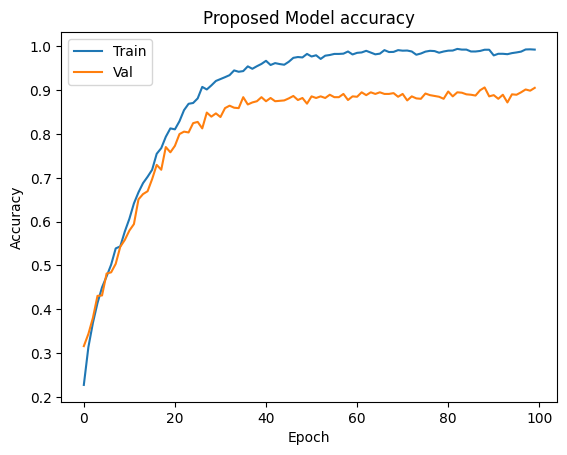

In [39]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Proposed Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

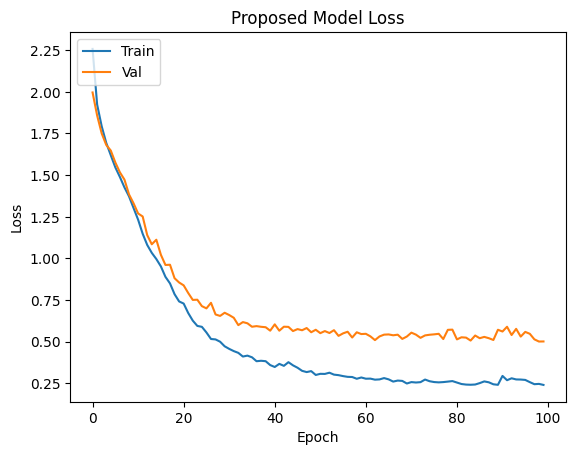

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Proposed Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

**Use the test data to do prediction**

In [19]:
y_pred = model.predict(XTestProcessed)

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


**Draw a confusion matrix**

<Axes: >

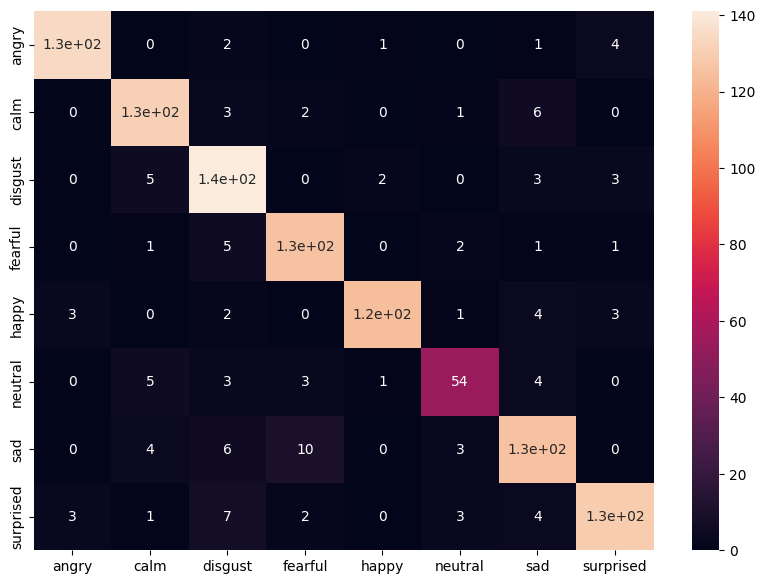

In [20]:
confusion_emotions = ['angry', 'calm', 'disgust', 'fearful','happy','neutral','sad','surprised']
cm=metrics.confusion_matrix(y_test,np.argmax(y_pred,axis=-1))
df_cm=pd.DataFrame(cm,index=[i for i in confusion_emotions],columns=[i for i in confusion_emotions])
plt.figure(figsize=(10,7))
sn.heatmap(df_cm,annot=True)

In [21]:
f1_score(y_test,np.argmax(y_pred,axis=1),average='weighted')


0.893593252185246

In [22]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
# Precision
precision = {}
for i, emotion in enumerate(confusion_emotions):
    precision[emotion] = precision_score(y_test, np.argmax(y_pred, axis=-1), labels=[i], average=None)

# Recall
recall = {}
for i, emotion in enumerate(confusion_emotions):
    recall[emotion] = recall_score(y_test, np.argmax(y_pred, axis=-1), labels=[i], average=None)

# Accuracy
accuracy = accuracy_score(y_test, np.argmax(y_pred, axis=-1))

print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)


Precision: {'angry': array([0.95714286]), 'calm': array([0.89115646]), 'disgust': array([0.83431953]), 'fearful': array([0.88111888]), 'happy': array([0.96875]), 'neutral': array([0.84375]), 'sad': array([0.84563758]), 'surprised': array([0.92142857])}
Recall: {'angry': array([0.94366197]), 'calm': array([0.91608392]), 'disgust': array([0.91558442]), 'fearful': array([0.92647059]), 'happy': array([0.90510949]), 'neutral': array([0.77142857]), 'sad': array([0.84563758]), 'surprised': array([0.86577181])}
Accuracy: 0.8935185185185185


**Model summary**

In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 180, 256)            │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 180, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 180, 128)            │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 180, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 180, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 22, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 22, 128)             │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 22, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 22, 128)             │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 22, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 22, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2816)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │          22,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 8)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,056,410 (4.03 MB)

 Trainable params: 352,136 (1.34 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 704,274 (2.69 MB)

## 6. Save and load the trained model.

In [ ]:
# Save the trained model to disk
if not os.path.exists('models'):
    os.makedirs('models')

model.save("models/cnn.h5")

In [ ]:
# Load the model from disk
loaded_model = keras.models.load_model("models/cnn.h5")

## 7. Playground

In [ ]:
# Load the data and extract features for each sound file
def load_single_data(file):
    x, y = [], []
    file_name = os.path.basename(file)
    emotion = emotions[file_name.split("-")[2]]
    data, sr = librosa.load(file)
    feature = extract_feature(data, sr, mfcc=True, chroma=True, mel=True)
    x.append(feature)
    y.append(emotion)
    return np.array(x), y

In [ ]:
XX, yy = load_single_data("data_directory/Actor_02/03-01-01-01-01-02-02.wav")

In [ ]:
yy

['neutral']

In [ ]:
# Predict for the test set
XXTemp=np.expand_dims(XX, axis=2)
model.predict(XXTemp)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


array([[2.14564404e-03, 1.18410867e-03, 2.55674659e-05, 7.59552277e-05,
        1.19933148e-03, 9.90350187e-01, 1.17861295e-04, 4.90127038e-03]],
      dtype=float32)

## 8. Base model with preprocessing

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling1D, Input, LSTM, Dense, Dropout, MultiHeadAttention, LayerNormalization
from tensorflow.keras.optimizers import SGD

def create_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # LSTM Layer
    lstm_out = LSTM(64, return_sequences=True)(inputs) #128
    lstm_out = Dropout(0.2)(lstm_out)
    # lstm_out = LSTM(128, return_sequences=True)(lstm_out) #128
    # lstm_out = Dropout(0.2)(lstm_out)
    # lstm_out = LayerNormalization(epsilon=1e-6)(lstm_out)

    # Transformer Layer
    for _ in range(4):

        attention_output = MultiHeadAttention(num_heads=4, key_dim=64)(lstm_out, lstm_out)
        attention_output = LayerNormalization(epsilon=1e-6)(attention_output + lstm_out)
        attention_output = Dropout(0.2)(attention_output)
        ff_output  = Dense(512, activation='relu')(attention_output)
        ff_output  = Dropout(0.2)(ff_output)
        # ff_output  = Dense(512, activation='relu')(ff_output)
        # ff_output  = Dropout(0.1)(ff_output)
        # ff_output  = Dense(256, activation='relu')(ff_output)
        # ff_output  = Dropout(0.1)(ff_output)
        ff_output  = Dense(64, activation='relu')(ff_output)
        ff_output  = Dropout(0.2)(ff_output)
        #ff_output  = Dense(64)(ff_output)
        lstm_out = LayerNormalization(epsilon=1e-6)(attention_output + ff_output)

    lstm_out = Dropout(0.2)(lstm_out)

    # Fully Connected Layers
    flatten = tf.keras.layers.Flatten()(lstm_out)
    dense_out = Dense(64)(flatten)
    dense_out = Dropout(0.2)(dense_out)
    outputs = Dense(num_classes, activation='softmax')(dense_out)

    model = Model(inputs, outputs)
    return model

# Define model parameters
input_shape = (x_train.shape[1], 1)  # Adjust as needed
num_classes = len(np.unique(y_train))

# Create the model
model = create_model(input_shape, num_classes)
optimizer = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [25]:
# from tensorflow.keras.callbacks import TensorBoard

# Reshape data for LSTM input
X_train_reshaped = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
X_test_reshaped = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

# Create log directory
# log_dir = os.path.join("logs", "fit", "model")
# tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train the model
history = model.fit(X_train_reshaped, y_train, epochs=750, batch_size=60, validation_data=(X_test_reshaped, y_test))


Epoch 1/750
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step - accuracy: 0.1504 - loss: 3.6601 - val_accuracy: 0.2398 - val_loss: 3.5361
Epoch 2/750
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.2009 - loss: 3.0422 - val_accuracy: 0.3204 - val_loss: 2.3197
Epoch 3/750
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.2431 - loss: 2.5523 - val_accuracy: 0.3343 - val_loss: 1.8562
Epoch 4/750
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.2384 - loss: 2.2656 - val_accuracy: 0.3389 - val_loss: 1.7924
Epoch 5/750
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.2805 - loss: 2.0272 - val_accuracy: 0.3546 - val_loss: 1.6933
Epoch 6/750
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.2760 - loss: 1.9866 - val_accuracy: 0.3722 - val_loss: 1.6918
Epoch 7/750
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.2832 - loss: 1.9102 - val_accuracy: 0.3583 - val_loss: 1.7445
Epoch 8/750
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.3089 - loss: 1.8744 - val_accuracy: 0

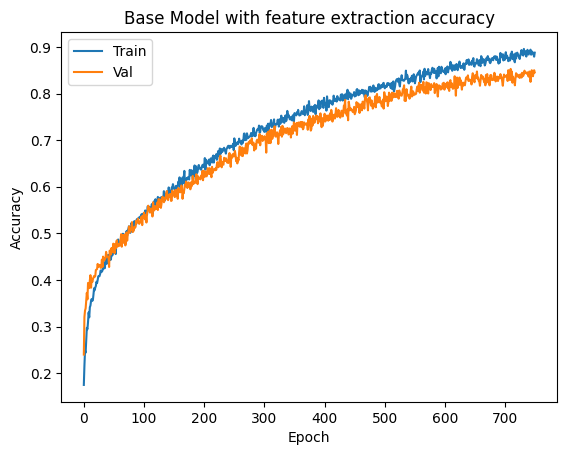

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Base Model with feature extraction accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

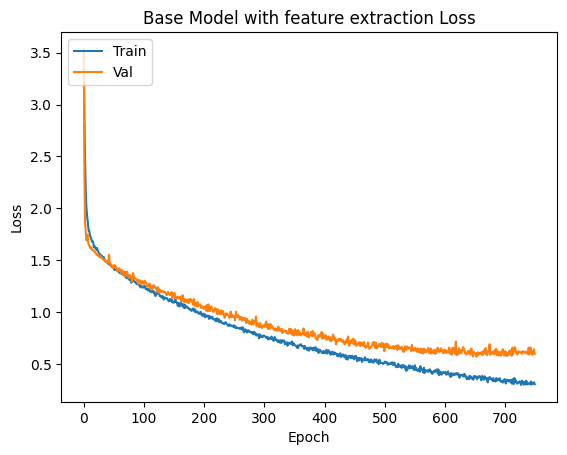

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Base Model with feature extraction Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [29]:
y_pred = model.predict(X_test_reshaped)

34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step


<Axes: >

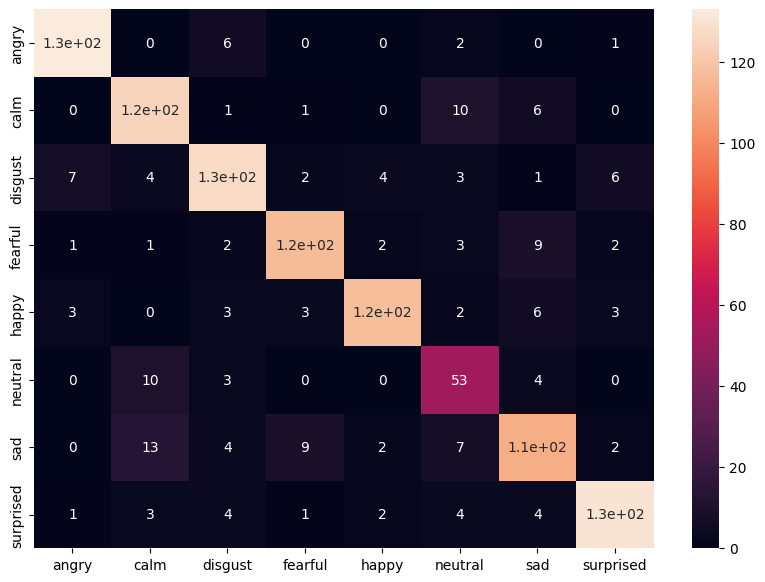

In [30]:
confusion_emotions = ['angry', 'calm', 'disgust', 'fearful','happy','neutral','sad','surprised']
cm=metrics.confusion_matrix(y_test,np.argmax(y_pred,axis=-1))
df_cm=pd.DataFrame(cm,index=[i for i in confusion_emotions],columns=[i for i in confusion_emotions])
plt.figure(figsize=(10,7))
sn.heatmap(df_cm,annot=True)

In [31]:
f1_score(y_test,np.argmax(y_pred,axis=1),average='weighted')

0.8463922165531425

In [32]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
# Precision
precision = {}
for i, emotion in enumerate(confusion_emotions):
    precision[emotion] = precision_score(y_test, np.argmax(y_pred, axis=-1), labels=[i], average=None)

# Recall
recall = {}
for i, emotion in enumerate(confusion_emotions):
    recall[emotion] = recall_score(y_test, np.argmax(y_pred, axis=-1), labels=[i], average=None)

# Accuracy
accuracy = accuracy_score(y_test, np.argmax(y_pred, axis=-1))

print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)

Precision: {'angry': array([0.91724138]), 'calm': array([0.80128205]), 'disgust': array([0.84666667]), 'fearful': array([0.87878788]), 'happy': array([0.92125984]), 'neutral': array([0.63095238]), 'sad': array([0.78873239]), 'surprised': array([0.90277778])}
Recall: {'angry': array([0.93661972]), 'calm': array([0.87412587]), 'disgust': array([0.82467532]), 'fearful': array([0.85294118]), 'happy': array([0.8540146]), 'neutral': array([0.75714286]), 'sad': array([0.75167785]), 'surprised': array([0.87248322])}
Accuracy: 0.8453703703703703


In [33]:
model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 180, 1)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 180, 64)        │         16,896 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 180, 64)        │              0 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 180, 64)        │         66,368 │ dropout_2[0][0],       │
│ (MultiHeadAttention)      │                        │                │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 180, 64)        │              0 │ multi_head_attention[… │
│                           │                        │                │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 180, 64)        │            128 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 180, 64)        │              0 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 180, 512)       │         33,280 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 180, 512)       │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 180, 64)        │         32,832 │ dropout_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 180, 64)        │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 180, 64)        │              0 │ dropout_4[0][0],       │
│                           │                        │                │ dropout_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 180, 64)        │            128 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 180, 64)        │         66,368 │ layer_normalization_1… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 180, 64)        │              0 │ multi_head_attention_… │
│                           │                        │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2

 Total params: 2,571,410 (9.81 MB)

 Trainable params: 1,285,704 (4.90 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,285,706 (4.90 MB)